# Mount Google Drive to access files

---
# Imports & Config  

## Notebook Loader

In [0]:
base_dir = "gdrive/My Drive/Masterarbeit"

classes_dict_file = base_dir + "/classes.pkl"

class FLAGS_IC:

  # directories & files for tmp storage
  image_dir = base_dir + "/ImageClassification/ImagePatches"
  bottleneck_dir = base_dir + "/ImageClassification/BottleneckFeatures"
  intermediate_output_graphs_dir = base_dir + "/ImageClassification/IntermediateGraphs"
  output_graph = base_dir + "/ImageClassification/output_graph.pb"
  saved_model_dir_base = base_dir + "/ImageClassification/ExportedGraphs"
  saved_model_dir = saved_model_dir_base + "/zzz"
  summaries_base_dir = base_dir + "/ImageClassification/Summaries"
  summaries_dir = summaries_base_dir + "/zzz"
  output_labels = base_dir + "/ImageClassification/OutputLabels"
  scores_dir = base_dir + "/ImageClassification/Scores"
  missclassified_dir = base_dir + "/ImageClassification/Missclassified"
  subfolder = "FineTuning"
  
  
  #objects pickle
  objects_dict_file = base_dir + "/objects.pkl"

  # folders to include
  folders = ["_Automat"]
  
  
  # class level
  class_level = [0,1] 


  # dataset splits
  use_prob_set_assignment =  True
  max_train_images = 1000
  validation_percentage = 20
  testing_percentage = 20
  # #2
  max_num_samples_per_class = 120
  min_num_samples_per_class = 120
  validation_n = 20 
  testing_n = 20
  
  early_stopping = True

  #k_fold
  k = 5
  num_per_fold = 20

  # ...
  eval_step_interval = 10
  intermediate_store_frequency = 100

  # Hyperparameter
  learning_rate = 0.0003
  how_many_training_steps = 400

  #regularization
  regularization_rate = 0.003
  
  # batch sizes
  train_batch_size = 100
  validation_batch_size = 200
  test_batch_size = -1

  # output
  print_misclassified_test_images = False
  final_tensor_name = "final_result"

  # random permutations
  flip_left_right = False
  random_crop = 0
  random_scale = 0
  random_brightness = 0

  #classification module
  tfhub_module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2'
  #'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
  
  #retrain layers
  cf_layer = 'softmax' #'sigmoid'
  bottleneck_layer = False
  
  #initialization
  initializer = 'xavier' #'normal', 'xavier'
  
  #optimizer
  optimizer = 'adam' #'adam', 'sgd'

class FLAGS_OD:
  image_dir = base_dir + "/ObjectDetection/Images"
  
  #images pickle
  images_dict_file = base_dir + "/images.pkl"
  
class FLAGS_TB:
  # a temporary folder to run tensorboard on, doesn't seem to run on a Gdrive mounted folder
  tmp_graph_dir = "/content/summaries"
  
  # how many images fit horizontally in an image mosaic
  tb_mosaic_width = 5

## Imports

## Connect to GPU

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Mount GDrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!gcloud config set project objectdetection-229309

# Create Dataset

In [0]:
import os
import tensorflow as tf

def get_xml_files(root_dir, selected_folders=None):
  """Gets all xml files recursively inside the root directory
  and returns the file names with the path
  Args:
    root_dir: root directory as string
    selected_folders: list of folder names which should only be
        used for the dataset. If None will use all.
  Returns:
    list of tuples with file_name and path_name relative from
        root_dir
  """
  file_list = []
  
  root_f = root_dir.split(os.sep)
  for path, _, files in tf.gfile.Walk(root_dir):
    path_f = path.split(os.sep)
    if not selected_folders is None and not \
        any(s_folder in path_f for s_folder in selected_folders):
      continue
    for file in files:
      if file.split(".")[-1] == "xml":
        rel_path = [f for f in path_f if f not in root_f]
        rel_path = os.path.join(*rel_path)
        file_list.append((file, rel_path))
  
  return file_list
  

In [0]:
import os
from bs4 import BeautifulSoup

def load_annotation(file_path, infos, use_gtin=False):
  """
  Load annotation file for a given image and parse xml to dict.
  Args:
    img_name: string of the image name.
    infos: dict with information that should be appended to image dict
  Returns:
    dict of the image with all infos
  """
  xml = ""
  with open(file_path, 'r') as f:
    xml = f.readlines()
  xml = ''.join([line.strip('\t') for line in xml])
  bs = BeautifulSoup(xml)
  image_filename = os.path.join(*(file_path.split(os.sep)[:-1]))
  filename = bs.filename.string.replace("\n","").replace("\t","").replace(" ","")
  image_filename = os.path.join(image_filename, filename)
  image = {"filename": image_filename.replace("\n",""),
           "size": {"width": int(bs.size.width.string),
                    "height": int(bs.size.height.string)},
           "objects": []}
  for key, val in infos.items():
    image[key] = val

  for ob in bs.find_all("object"):
    name = ob.find('name').string.replace("\n","").replace("\t","").replace(" ","")
    if use_gtin:
      name_parts = name.split("_")
      if len(name_parts) == 6:
        name = "gtin" + name_parts[-1]
          
    obj = {"name": name,
           "bndbox":{"xmin": int(ob.bndbox.xmin.string),
                     "xmax": int(ob.bndbox.xmax.string),
                     "ymin": int(ob.bndbox.ymin.string),
                     "ymax": int(ob.bndbox.ymax.string)},
           "pose":ob.pose.string,
           "truncated": bool(ob.truncated.string),
           "difficult": bool(ob.difficult.string)}
    image["objects"].append(obj)
  return image

In [0]:
def get_filename_clean(filename):
  return ".".join(filename.split("/")[-1].split(".")[:-1])

def img_filesuffix(objname, filename):
  return os.path.join(FLAGS_IC.image_dir,
                      objname,
                      get_filename_clean(filename))

In [0]:
import os
import glob

def check_if_image_patches_exist(image_dict):
  """
  Check if for an image_dict the expected number of objects exist
  Args:
    image_dict: dictonary with all the image information
  Returns:
    true if correct number of image patches else false
  """
  num_objs_exist = 0
  list_of_patches = {}
  for obj in image_dict["objects"]:
    if os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      files = glob.glob('{}*.png'.format(img_filesuffix(obj["name"], image_dict["filename"])))
      for file in files:
        if not file in list_of_patches:
          num_objs_exist += 1
          list_of_patches[file] = [file, image_dict["filename"], obj["name"]]
  
  if num_objs_exist == len(image_dict["objects"]):
    return True, list_of_patches
  else:
    return False, list_of_patches

In [0]:
import os
import glob

def clean_for_image(image_dict):
  """
  Clean out all image patches beloging to the image_dict
  Args:
    image_dict: dictonary with all the image information  
  """
  for obj in image_dict["objects"]:
    if os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      files = glob.glob('{}*.png'.format(img_filesuffix(obj["name"], image_dict["filename"])))
      for file in files:
        assert (os.path.isfile(file) and FLAGS_IC.image_dir in file), "Cannot delete this something is wrong with {}".format(file)
        print("file: removing ", file)
        os.remove(file)

In [0]:
import random
import os
from PIL import Image

def extract_image_patches(image_dict):
  """
  for every patch create a new file and save it in a folder named as the object
  and the filename named after the image plus a random number to allow multi
  objects per image
  Args:
    image_dict: dictonary with all the image information
  """
  if os.path.exists(image_dict["filename"]):
    im=Image.open(image_dict["filename"])
  else:
    return
  
  list_of_patches = {}
  for obj in image_dict["objects"]:
    if not os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      os.mkdir(os.path.join(FLAGS_IC.image_dir,obj["name"]))
      #print("dir: created ", obj["name"])
    
    bndbox = obj["bndbox"]
    bndbox = (bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"])
    
    im2=im.crop(bndbox)

    image_patch_file = img_filesuffix(obj["name"], image_dict["filename"]) + "_" + str(random.randint(0,9999999)) + ".png" 
    im2.save(image_patch_file)
    #print("file: created ", image_patch_file)
    
    list_of_patches[image_patch_file] = [image_patch_file, image_dict["filename"], obj["name"]]
    
  return list_of_patches

In [0]:
files = get_xml_files(FLAGS_OD.image_dir, FLAGS_IC.folders)

image_patches = {}

n = len(files)
for it, file in enumerate(files):
  if it % 10 == 0:
    print("working on: ", it, "/", n)
  image_dict = load_annotation(os.path.join(FLAGS_OD.image_dir, file[1], file[0]), {})
  file_done, image_patches_per_file = check_if_image_patches_exist(image_dict)
  if not file_done:
    clean_for_image(image_dict)
    image_patches_per_file = extract_image_patches(image_dict)
  else:
    pass
    #print("skipping ", image_dict["filename"])
  image_patches.update(image_patches_per_file)
    
with open(os.path.join(FLAGS_IC.image_dir,"list_of_patches.csv"), "w+") as file:
  file.write("name;filename;class_name\n")
  file.write("\n".join(['"' + "/".join(image_patch[0].split(os.sep)[-2:]) + '";"' + '";"'.join(image_patch[1:]) + '"' for image_patch in image_patches.values()]))

working on:  0 / 295
working on:  100 / 295
working on:  200 / 295


# Image Classification

In [0]:
# Image Recognition imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os
import os.path
import random
import re
import sys

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from io import BytesIO

from PIL import Image, ImageFont, ImageDraw
import numpy as np

MAX_NUM_IMAGES_PER_CLASS = 1000   #2 ** 27 - 1  # ~134M

# A module is understood as instrumented for quantization with TF-Lite
# if it contains any of these ops.
FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars',
                  'FakeQuantWithMinMaxVarsPerChannel')


In [0]:
import collections
import os
import tensorflow as tf
import hashlib
MAX_NUM_IMAGES_PER_CLASS = 1000   #2 ** 27 - 1  # ~134M

def create_image_lists(image_dir, testing_percentage, validation_percentage):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Builds a list of training images from the file system.
  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.
  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.
  Returns:
    An OrderedDict containing an entry for each label subfolder, with images
    split into training, testing, and validation sets within each label.
    The order of items defines the class indices.
  """
  if not tf.gfile.Exists(image_dir):
    tf.logging.error("Image directory '" + image_dir + "' not found.")
    return None
  result = collections.OrderedDict()
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))
  # The root directory comes first, so skip it.
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = sorted(set(os.path.normcase(ext)  # Smash case on Windows.
                            for ext in ['JPEG', 'JPG', 'jpeg', 'jpg', 'PNG', 'png']))
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    #tf.logging.info("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    if not file_list:
      tf.logging.warning('No files found')
      continue
    if len(file_list) < 10:
      tf.logging.warning(
          'WARNING: Folder has less than 10 images, which may cause issues. skipping')
      continue
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      tf.logging.warning(
          'WARNING: Folder {} has more than {} images. Some images will '
          'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    cnt_train_images = 0
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(tf.compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        if not FLAGS_IC.use_prob_set_assignment and cnt_train_images >= FLAGS_IC.max_train_images:
          if ((percentage_hash - (testing_percentage + validation_percentage) / 
              (1 - (testing_percentage + validation_percentage))) < validation_percentage /
              (testing_percentage + validation_percentage)):
            validation_images.append(base_name)
          else:
            testing_images.append(base_name)
        else:
          training_images.append(base_name)
          cnt_train_images += 1
    tf.logging.info("label: {}".format(label_name))
    tf.logging.info("\ttrain: {}".format(len(training_images)))
    tf.logging.info("\tvalid: {}".format(len(validation_images)))
    tf.logging.info("\ttest: {}".format(len(testing_images)))
    
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result

In [0]:
import pandas as pd

def create_image_lists_from_csv(csv_file, testing_n=None, testing_frac=None,
                                validation_n=None, validation_frac=None,
                                max_num=None, min_num=None):
  """Takes all image patches described in the csv file and randomly assigns them
  to fixed classes. if the percentages are give > 1 they are interpreted as count
  otherwise they are interpreted as percentage.
  Args:
    csv_file: the path to the csv file where all the image patches are described
    testing_percentage: the percentage or number of files that should be in the test set
    validation_percentage: the percentage or number of files that should be in the validation set
    max_num: the max number of files distributed among all sets
    min_num: the min number of files distributed among all sets
  Returns:
    saves the csv_file with the assignment per class
    returns a dict with the patches for training, testing, validation.
  
  """
  random_state = 17
  result = {}
  #name;filename;class_name;set
  df = pd.read_csv(csv_file, sep=";", quotechar='"')
  for it, obj_class in enumerate(df["class_name"].value_counts().sort_values(ascending=False).iteritems()):
    if not min_num is None and obj_class[1] < min_num:
      continue
    
    #shuffle elems
    sample_elems = df.loc[df["class_name"]==obj_class[0],"name"].sample(n=min(max_num, obj_class[1]),
                                                                        random_state=random_state)
    
    testing_images = sample_elems.sample(n=testing_n,
                                         frac=testing_frac,
                                         random_state=random_state).tolist()
    df.loc[df["name"].apply(lambda x: x in testing_images), "set"] = "testing"
    
    sample_elems = sample_elems.loc[sample_elems.apply(lambda x: not x in testing_images)]
    
    validation_images = sample_elems.sample(n=validation_n,
                                            frac=validation_frac,
                                            random_state=random_state).tolist()
    df.loc[df["name"].apply(lambda x: x in validation_images), "set"] = "validation"
    
    training_images = sample_elems.loc[sample_elems.apply(lambda x: not x in validation_images)].tolist()
    df.loc[df["name"].apply(lambda x: x in training_images), "set"] = "training"
    
    
    result[obj_class[0]] = {
        'dir': obj_class[0],
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
    
  #df["name"] = df["name"].apply(lambda x: x.split("/")[-1])
  #df.to_csv(os.path.join(FLAGS_IC.image_dir,"list_of_patches_finaltest.csv"), sep=";", quotechar='"')
            
  return result
  

In [0]:
#create_image_lists_from_csv(os.path.join(FLAGS_IC.image_dir,"list_of_patches.csv"),
#                            testing_n=20, validation_n=20, max_num=120, min_num=100)

In [0]:
def read_image_lists_from_csv(csv_file):
  """This function reads the dataset from a given csv file
  """
  result = {}
  #name;filename;class_name;set
  df = pd.read_csv(csv_file, sep=";", quotechar='"')
  for it, obj_class in enumerate(df["class_name"].value_counts().sort_values(ascending=False).iteritems()):
    cl = (df["class_name"] == obj_class[0])
    if df[cl & (df["set"] == "training")]["name"].size > 0:
      result[obj_class[0]] = {
          'dir': obj_class[0],
          'training': df[cl & (df["set"] == "training")]["name"].tolist(),
          'testing': df[cl & (df["set"] == "testing")]["name"].tolist(),
          'validation': df[cl & (df["set"] == "validation")]["name"].tolist(),
      }
    
  return result
    

In [0]:
import random
import queue

class k_fold_split:
  """creates a k_fold split on the training images with num_per_batch 
  randomly sampled images per fold with k fold provide through a
  generator
  """
  def __init__(self, image_lists, k, num_per_batch=None):
    self.image_lists = image_lists
    self.n = -1
    self.k = k
    self.queues = {}
    self.num_per_batch = {}
    for key, val in self.image_lists.items():
      self.queues[key] = queue.Queue()
      random.shuffle(val["training"])
      for elem in val["training"]:
        self.queues[key].put(elem)
      
      if num_per_batch is None or num_per_batch * k > len(val["training"]):
        self.num_per_batch[key] = int(len(val["training"]) / k)
      else:
        self.num_per_batch[key] = num_per_batch
    
  def __iter__(self):
    return self
  
  def __next__(self):
    self.n += 1
    if self.n < self.k:
      result = {}
      for key, val in self.image_lists.items():    
        result[key] = {
          'dir': key,
          'training': [self.queues[key].get() for _ in range(0,self.num_per_batch[key])],
          'validation': val["validation"],
          'testing': val['testing']
        }
      
      return result
    else:
      raise StopIteration()
    

In [0]:
def get_image_path(image_lists, label_name, index, image_dir, category):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Returns a path to an image for a label at the given index.
  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.
  Returns:
    File system path string to an image that meets the requested parameters.
  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path

In [0]:
def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Returns a path to a bottleneck file for a label at the given index.
  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    module_name: The name of the image module being used.
  Returns:
    File system path string to an image that meets the requested parameters.
  """
  module_name = (module_name.replace('://', '~')  # URL scheme.
                 .replace('/', '~')  # URL and Unix paths.
                 .replace(':', '~').replace('\\', '~'))  # Windows paths.
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '_' + module_name + '.txt'

In [0]:
def create_module_graph(module_spec):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Creates a graph and loads Hub Module into it.
  Args:
    module_spec: the hub.ModuleSpec for the image module being used.
  Returns:
    graph: the tf.Graph that was created.
    bottleneck_tensor: the bottleneck values output by the module.
    resized_input_tensor: the input images, resized as expected by the module.
    wants_quantization: a boolean, whether the module has been instrumented
      with fake quantization ops.
  """
  height, width = hub.get_expected_image_size(module_spec)
  with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec, trainable=True, tags={"train"})
    bottleneck_tensor = m(inputs=dict(images=resized_input_tensor, batch_norm_momentum=0.99),
                          signature="image_feature_vector_with_bn_hparams")
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)
    
  return graph, bottleneck_tensor, resized_input_tensor, wants_quantization

In [0]:
def get_trainable_vars(final_layer_scope, fine_tune_scope):
  """
  
  
  """
  with tf.Graph().as_default() as graph:
    # Find out the names of all variables present in graph
    print(tf.all_variables())

    # After finding the names of variables or scope, gather the variables you wish to fine-tune
    train_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=final_layer_scope)
    train_var_list.extend(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=fine_tune_scope))
    
  return train_var_list

In [0]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Runs inference on an image to extract the 'bottleneck' summary layer.
  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.
  Returns:
    Numpy array of bottleneck values.
  """
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,
                                  {image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,
                               {resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values

In [0]:
def ensure_dir_exists(dir_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Makes sure the folder exists on disk.
  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [0]:
def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Create a single bottleneck file."""
  tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = tf.gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, image_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path,
                                                                 str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)

In [0]:
def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, image_data_tensor,
                             decoded_image_tensor, resized_input_tensor,
                             bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Retrieves or calculates bottleneck values for an image.
  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.
  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of which set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    module_name: The name of the image module being used.
  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category, module_name)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    tf.logging.warning('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values

In [0]:
def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      image_data_tensor, decoded_image_tensor,
                      resized_input_tensor, bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Ensures all the training, testing, and validation bottlenecks are cached.
  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.
  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    module_name: The name of the image module being used.
  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(
            sess, image_lists, label_name, index, image_dir, category,
            bottleneck_dir, image_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 100 == 0:
          tf.logging.info(
              str(how_many_bottlenecks) + ' bottleneck files created.')

In [0]:
#(train_bottlenecks,
# train_ground_truth, _) = get_random_cached_bottlenecks(
#     sess, image_lists, FLAGS_IC.train_batch_size, 'training',
#     FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
#     decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
#     FLAGS_IC.tfhub_module)


def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, image_data_tensor,
                                  decoded_image_tensor, resized_input_tensor,
                                  bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Retrieves bottleneck values for cached images.
  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.
  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
              If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    image_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    module_name: The name of the image module being used.
  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(
          sess, image_lists, label_name, image_index, image_dir, category,
          bottleneck_dir, image_data_tensor, decoded_image_tensor,
          resized_input_tensor, bottleneck_tensor, module_name)
      bottlenecks.append(bottleneck)
      ground_truths.append(label_index)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, image_dir, category,
            bottleneck_dir, image_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)
        bottlenecks.append(bottleneck)
        ground_truths.append(label_index)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames

In [0]:
def get_random_image_patches(sess, image_lists, how_many, category,
                             image_dir, image_data_tensor, decoded_image_tensor):
  """Get a random batch of image patches from the image_dir
  including the ground_truth data.
  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
              If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    image_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
  Returns:
    List of resized and decode image patches, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  image_patches = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_path = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      
      if not tf.gfile.Exists(image_path):
        tf.logging.fatal('File does not exist %s', image_path)
      
      image_data = tf.gfile.FastGFile(image_path, 'rb').read()
      
      image_patch = sess.run(decoded_image_tensor,
                             {image_data_tensor: image_data})
      
      image_patches.append(image_patch)
      ground_truths.append(label_index)
      filenames.append(image_path)
  
  return image_patches, ground_truths, filenames

In [0]:
def variable_summaries(var):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [0]:
def add_final_retrain_ops(class_count, final_tensor_name, bottleneck_tensor,
                          quantize_layer, is_training, training_var_list=None):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Adds a new softmax and fully-connected layer for training and eval.
  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.
  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/tutorials/mnist/beginners/index.html
  Args:
    class_count: Integer of how many categories of things we're trying to
        recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    quantize_layer: Boolean, specifying whether the newly added layer should be
        instrumented for quantization with TF-Lite.
    is_training: Boolean, specifying whether the newly add layer is for training
        or eval.
  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  batch_size, bottleneck_tensor_size = bottleneck_tensor.get_shape().as_list()
  assert batch_size is None, 'We want to work with arbitrary batch size.'
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor,
        shape=[batch_size, bottleneck_tensor_size],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(
        tf.int64, [batch_size], name='GroundTruthInput')

  # Allow switching to xavier initializer
  if not is_training:
    weight_init = None
  else:
    if FLAGS_IC.initializer == "xavier":
      tf.logging.info("Using XavierInitializer")
      weight_init = tf.contrib.layers.xavier_initializer()
    else:
      tf.logging.info("Using TruncatedNormalInitializer")
      weight_init = tf.truncated_normal_initializer(stddev=0.001)
  
  # batch norm after bottleneck
  batch_norm = tf.layers.batch_normalization(
      bottleneck_input,
      axis=-1,
      momentum=0.99,
      epsilon=0.001,
      center=True,
      scale=True,
      beta_initializer=tf.zeros_initializer(),
      gamma_initializer=tf.ones_initializer(),
      moving_mean_initializer=tf.zeros_initializer(),
      moving_variance_initializer=tf.ones_initializer(),
      beta_regularizer=None,
      gamma_regularizer=None,
      beta_constraint=None,
      gamma_constraint=None,
      training=False,
      trainable=True,
      name=None,
      reuse=None,
      renorm=False,
      renorm_clipping=None,
      renorm_momentum=0.99,
      fused=None,
      virtual_batch_size=None,
      adjustment=None
  )
  
  # final layer
  logits = tf.layers.dense(
      inputs=batch_norm,
      units=class_count,
      activation=None,
      use_bias=True,
      kernel_initializer=weight_init,
      bias_initializer=tf.zeros_initializer(),
      kernel_regularizer=tf.contrib.layers.l2_regularizer(FLAGS_IC.regularization_rate),
      bias_regularizer=None,
      activity_regularizer=None,
      trainable=True,
      name='final_retrain_ops',
  )
  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)

  # The tf.contrib.quantize functions rewrite the graph in place for
  # quantization. The imported model graph has already been rewritten, so upon
  # calling these rewrites, only the newly added final layer will be
  # transformed.
  if quantize_layer:
    if is_training:
      tf.contrib.quantize.create_training_graph()
    else:
      tf.contrib.quantize.create_eval_graph()

  #During training create a couple of summaries
  if is_training:
    tf.logging.info(tf.global_variables(scope='final_retrain_ops'))
    with tf.variable_scope('final_retrain_ops', reuse=True):
      variable_summaries(tf.get_variable('kernel'))
      variable_summaries(tf.get_variable('bias'))
    tf.summary.histogram('pre_activations', logits)
    tf.summary.histogram('activations', final_tensor)
  
  # If this is an eval graph, we don't need to add loss ops or an optimizer.
  if not is_training:
    return None, None, bottleneck_input, ground_truth_input, final_tensor

  with tf.name_scope('cross_entropy'):
    #TODO maybe we need + tf.losses.get_regularization_losses() 
    # added with regularization constant
    cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
        labels=ground_truth_input, logits=logits) + tf.losses.get_regularization_loss()

  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  #Allow switching between different Optimizers
  with tf.name_scope('train'):
    if FLAGS_IC.optimizer == "adam":
      tf.logging.info("Using AdamOptimizer")
      optimizer = tf.train.AdamOptimizer(FLAGS_IC.learning_rate)
    else:
      tf.logging.info("Using GradientDescentOptimizer")
      optimizer = tf.train.GradientDescentOptimizer(FLAGS_IC.learning_rate)
    # TODO let's try optimizing everything first otherwise
    # var_list=training_var_list
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)

In [0]:
def add_evaluation_step(result_tensor, ground_truth_tensor):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Inserts the operations we need to evaluate the accuracy of our results.
  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.
  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('prediction'):
    prediction = tf.argmax(result_tensor, 1)
  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(prediction, ground_truth_tensor)
    evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', evaluation_step)
  with tf.name_scope('confusion_matrix'):
    confusion_matrix = tf.confusion_matrix(labels=ground_truth_tensor,
                                           predictions=prediction)
    tf.summary.tensor_summary('confusion_matrix', confusion_matrix)
  return evaluation_step, prediction, confusion_matrix

In [0]:
def plot_confusion_matrix(confusion_matrix, image_lists):
  #adapted from: https://github.com/tensorflow/tensorboard/issues/227
  #& https://stackoverflow.com/questions/41617463/tensorflow-confusion-matrix-in-tensorboard
  '''Plot a confusion matrix plot, based on a confusion matrix. Then convert
  matplotlib figure into a TensorFlow Summary object that can be directly fed
  into Summary.FileWriter.
  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data into.
    image_lists: the dict holding the lists of images for all classes
  Returns:  
    fig_tensor: a tensor of the fig
    confusion_matrix: the confusion matrix
  '''
  #create the labels
  classes_list = list(image_lists.keys())
  
  # create the plot
  plt.figure()
  ax = sns.heatmap(confusion_matrix, xticklabels=False, cmap="viridis")
  ax.set(xlabel='Predicted', ylabel='True Label')
  ax.yaxis.set_label_position("right")
  ax.set_yticklabels(classes_list)
  ax.tick_params(axis="y", labelrotation=0)
  
  #fig.set_tight_layout(True)
  fig = ax.get_figure()
  
  # attach a new canvas if not exists
  if fig.canvas is None:
    FigureCanvas(fig)

  fig.canvas.draw()
  w, h = fig.canvas.get_width_height()

  # get PNG data from the figure
  png_buffer = BytesIO()
  fig.canvas.print_png(png_buffer)
  png_encoded = png_buffer.getvalue()
  png_buffer.close()
  plt.close()

  summary_image = tf.Summary.Image(height=h, width=w, colorspace=4,  # RGB-A
                                encoded_image_string=png_encoded)
  summary = tf.Summary(value=[tf.Summary.Value(tag="confusion_matrix",
                                               image=summary_image)])

  return summary

In [0]:
def calc_mosaic_size(num_total, input_height, input_width):
  """Calculate the total width and height of the image mosaic
  and return the positions of the individual images and label
  names on the images
  Args:
    num_total: Total number of images in the mosaic
    input_height, input_width: Size of the image patch
  Returns:
    total_height: Total height of combined image
    total_width: Total width of combined image
    img_pos_list: list of the indices of the positions of each 
        image
    text_pos_list: list of the indices of the positions of each 
        label text 
  """
  pxl_delim = 15
  max_num_width = FLAGS_TB.tb_mosaic_width
  
  if num_total > max_num_width:
    num_width = max_num_width
    num_height = int(num_total/ max_num_width) + 1
  else:
    num_width = num_total
    num_height = 1
    
  total_width = (input_width + pxl_delim) * num_width
  total_height = (input_height + pxl_delim) * num_height
    
  img_pos_list = []
  for w in range(0, total_width, input_width + pxl_delim):
    for h in range(0, total_height, input_height + pxl_delim):
      img_pos_list.append((w,h))
  
  text_pos_list = []    
  for w in range(0, total_width, input_width + pxl_delim):
    for h in range(input_height + 2, total_height, input_height + pxl_delim):
      text_pos_list.append((w,h))
      
  return total_width, total_height, img_pos_list, text_pos_list

In [0]:
def create_misclassified_summary(test_writer, misclassified, module_spec):
  """gets the misclassified images and creates per correct label one image 
  mosaic and adds the predicted labels to the mosaic. Then saves the mosaic as an
  image summary for tensorboard 
  Args:
    misclassified: dict with correct labels as keys and lists of tuples 
        (predicted label, filename) of false classified images. 
    module_spec: The hub.ModuleSpec for the image module being used.
  Returns:
    mosaic_images: a dict with key as the label and value as a raw image data from PIL
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  for key, val in misclassified.items():
    total_width, total_height, img_pos_list, text_pos_list = calc_mosaic_size(len(val),
                                                                              input_height,
                                                                              input_width)
    
    mosaic_image = Image.new('RGB', (total_width, total_height), (255,255,255))
    d = ImageDraw.Draw(mosaic_image)
    
    for it, img_file in enumerate(val):
      img = Image.open(img_file[1])
      img_resized = img.resize((input_width, input_height))
      mosaic_image.paste(img_resized, img_pos_list[it])
      d.text(text_pos_list[it], img_file[0], fill=(0,0,0))

    png_buffer = BytesIO()
    plt.imsave(fname=png_buffer, arr=mosaic_image, format="png")
    png_encoded = png_buffer.getvalue()
    png_buffer.close()
    mosaic_summary_img = tf.Summary.Image(height=total_height, width=total_width,
                                          encoded_image_string=png_encoded)
    mosaic_summary = tf.Summary(value=[tf.Summary.Value(tag="misclassified/{}".format(key),
                                                        image=mosaic_summary_img)])
    test_writer.add_summary(mosaic_summary, FLAGS_IC.how_many_training_steps)

In [0]:
def run_final_eval(train_session, module_spec, class_count, image_lists,
                   image_data_tensor, decoded_image_tensor,
                   resized_image_tensor, bottleneck_tensor,
                   checkpoint):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Runs a final evaluation on an eval graph using the test data set.
  Args:
    train_session: Session for the train graph with the tensors below.
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
    image_lists: OrderedDict of training images for each label.
    image_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_image_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  """
  (eval_session, bottleneck_tensor, image_data_tensor, ground_truth_input, evaluation_step,
   prediction, confusion_matrix, merged, decoded_image_tensor, resized_input_tensor) = build_eval_session(module_spec, class_count, checkpoint)
  
  misclassified = {}
  total_test_accuracy = 0
  
  for it in range(0, FLAGS_IC.validation_batch_size[1]):
  
    (test_image_patches, test_ground_truth, test_filenames) = get_random_image_patches(
          eval_session, image_lists, FLAGS_IC.validation_batch_size[0], 'testing',
          FLAGS_IC.image_dir, image_data_tensor, decoded_image_tensor)

    test_summary, test_accuracy, predictions, test_confusion_matrix = eval_session.run(
        [merged, evaluation_step, prediction, confusion_matrix],
        feed_dict={resized_input_tensor: test_image_patches,
                   ground_truth_input: test_ground_truth})

    total_test_accuracy += test_accuracy / FLAGS_IC.validation_batch_size[1]

    test_writer = tf.summary.FileWriter(FLAGS_IC.summaries_dir + '/test')
    test_writer.add_summary(test_summary, FLAGS_IC.how_many_training_steps)

    test_summary_cmp = plot_confusion_matrix(test_confusion_matrix, image_lists)
    test_writer.add_summary(test_summary_cmp, FLAGS_IC.how_many_training_steps)

    class_names = list(image_lists.keys())

    if FLAGS_IC.print_misclassified_test_images:
      tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
    for i, test_filename in enumerate(test_filenames):
      _prediction = predictions[i]
      _correct_label = test_ground_truth[i]
      if _prediction != _correct_label:
        if not class_names[_correct_label] in misclassified:
          misclassified[class_names[_correct_label]] = []
        misclassified[class_names[_correct_label]].append((class_names[_prediction],
                                                test_filename))  
        if FLAGS_IC.print_misclassified_test_images:
          tf.logging.info('%70s  %s' % (test_filename, class_names[_prediction]))
        
  create_misclassified_summary(test_writer, misclassified, module_spec)
    
  tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                    (total_test_accuracy * 100, len(test_image_patches)))
    
  return total_test_accuracy, misclassified

In [0]:
def build_eval_session(module_spec, class_count, checkpoint):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Builds an restored eval session without train operations for exporting.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """
  # If quantized, we need to create the correct eval graph for exporting.
  eval_graph, bottleneck_tensor, resized_input_tensor, wants_quantization = (
      create_module_graph(module_spec))
  
  eval_sess = tf.Session(graph=eval_graph)
  with eval_graph.as_default():
    # Add the new layer for exporting.
    (_, _, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=False)

    # Set up the image decoding sub-graph.
    image_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)
    
    # Now we need to restore the values from the training graph to the eval
    # graph.
    tf.train.Saver().restore(eval_sess, checkpoint)

    evaluation_step, prediction, confusion_matrix = add_evaluation_step(
        final_tensor, ground_truth_input)
    merged = tf.summary.merge_all()

  return (eval_sess, bottleneck_tensor, image_data_tensor, ground_truth_input,
          evaluation_step, prediction, confusion_matrix, merged,
          decoded_image_tensor, resized_input_tensor)

In [0]:
def save_graph_to_file(graph_file_name, module_spec, class_count, checkpoint):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Saves an graph to file, creating a valid quantized one if necessary."""
  sess, _, _, _, _, _, _, _, _, _ = build_eval_session(module_spec, class_count, checkpoint)
  graph = sess.graph

  output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FLAGS_IC.final_tensor_name])

  with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())

In [0]:
def prepare_file_system():
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  # Set up the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS_IC.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS_IC.summaries_dir)
  tf.gfile.MakeDirs(FLAGS_IC.summaries_dir)
  if FLAGS_IC.intermediate_store_frequency > 0:
    ensure_dir_exists(FLAGS_IC.intermediate_output_graphs_dir)
  return

In [0]:
def add_jpeg_decoding(module_spec):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Adds operations that perform image decoding and resizing to the graph..
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
  Returns:
    Tensors for the node to feed image data into, and the output of the
      preprocessing steps.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_image(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  resized_image = tf.squeeze(resized_image)
  return jpeg_data, resized_image

In [0]:
def export_model(module_spec, class_count, saved_model_dir, checkpoint):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Exports model for serving.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """
  # The SavedModel should hold the eval graph.
  sess, in_image, _, _, _, _, _, _, _, _ = build_eval_session(module_spec, class_count, checkpoint)
  with sess.graph.as_default() as graph:
    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={'image': in_image},
        outputs={'prediction': graph.get_tensor_by_name('final_result:0')},
        legacy_init_op=tf.group(tf.tables_initializer(), name='legacy_init_op')
    )

## Normal Way

In [0]:
def main(_):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
  tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS_IC.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS_IC.image_dir, FLAGS_IC.testing_percentage,
                                   FLAGS_IC.validation_percentage)
  class_count = len(image_lists.keys())
  
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS_IC.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS_IC.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS_IC.flip_left_right, FLAGS_IC.random_crop, FLAGS_IC.random_scale,
      FLAGS_IC.random_brightness)
  
  # Set up the pre-trained graph.
  module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
  graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
      create_module_graph(module_spec))

  # Add the new layer that we'll be training.
  with graph.as_default():
    (train_step, cross_entropy, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=True)

  with tf.Session(graph=graph) as sess:
    # Initialize all weights: for the module to their pretrained values,
    # and for the newly added retraining layer to random initial values.
    init_global = tf.global_variables_initializer()
    sess.run(init_global)
    
    # Set up the image decoding sub-graph.
    image_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

    if do_distort_images:
      # We will be applying distortions, so set up the operations we'll need.
      (distorted_image_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS_IC.flip_left_right, FLAGS_IC.random_crop, FLAGS_IC.random_scale,
           FLAGS_IC.random_brightness, module_spec)
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS_IC.image_dir,
                        FLAGS_IC.bottleneck_dir, image_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS_IC.tfhub_module)

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, _, confusion_matrix = add_evaluation_step(final_tensor, ground_truth_input)
    
    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    
    train_writer = tf.summary.FileWriter(FLAGS_IC.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS_IC.summaries_dir + '/validation')

    # Create a train saver that is used to restore values into an eval graph
    # when exporting models.
    train_saver = tf.train.Saver()

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS_IC.how_many_training_steps):
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS_IC.train_batch_size, 'training',
             FLAGS_IC.image_dir, distorted_image_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS_IC.train_batch_size, 'training',
             FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
             decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
             FLAGS_IC.tfhub_module)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.
      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS_IC.how_many_training_steps)
      if (i % FLAGS_IC.eval_step_interval) == 0 or is_last_step:
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                        (datetime.now(), i, train_accuracy * 100))
        tf.logging.info('%s: Step %d: Cross entropy = %f' %
                        (datetime.now(), i, cross_entropy_value))
        # TODO: Make this use an eval graph, to avoid quantization
        # moving averages being updated by the validation set, though in
        # practice this makes a negligable difference.
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS_IC.validation_batch_size, 'validation',
                FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
                decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                FLAGS_IC.tfhub_module))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy, validation_confusion_matrix = sess.run(
            [merged, evaluation_step, confusion_matrix],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                        (datetime.now(), i, validation_accuracy * 100,
                         len(validation_bottlenecks)))
        validation_summary_cmp = plot_confusion_matrix(validation_confusion_matrix, image_lists)
        validation_writer.add_summary(validation_summary_cmp, i)

      # Store intermediate results
      intermediate_frequency = FLAGS_IC.intermediate_store_frequency

      if (intermediate_frequency > 0 and (i % intermediate_frequency == 0)
          and i > 0):
        # If we want to do an intermediate save, save a checkpoint of the train
        # graph, to restore into the eval graph.
        train_saver.save(sess, CHECKPOINT_NAME)
        intermediate_file_name = (FLAGS_IC.intermediate_output_graphs_dir +
                                  'intermediate_' + str(i) + '.pb')
        tf.logging.info('Save intermediate result to : ' +
                        intermediate_file_name)
        save_graph_to_file(intermediate_file_name, module_spec,
                           class_count)

    # After training is complete, force one last save of the train checkpoint.
    train_saver.save(sess, CHECKPOINT_NAME)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    run_final_eval(sess, module_spec, class_count, image_lists,
                   image_data_tensor, decoded_image_tensor, resized_image_tensor,
                   bottleneck_tensor)

    # Write out the trained graph and labels with the weights stored as
    # constants.
    tf.logging.info('Save final result to : ' + FLAGS_IC.output_graph)
    if wants_quantization:
      tf.logging.info('The model is instrumented for quantization with TF-Lite')
    save_graph_to_file(FLAGS_IC.output_graph, module_spec, class_count)
    with tf.gfile.FastGFile(FLAGS_IC.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')

    if FLAGS_IC.saved_model_dir:
      export_model(module_spec, class_count, FLAGS_IC.saved_model_dir)



In [0]:
from datetime import datetime
now = datetime.now()

FLAGS_IC.train_batch_size = 400
FLAGS_IC.validation_batch_size = 200
FLAGS_IC.learning_rate = 0.003
FLAGS_IC.how_many_training_steps = 200
FLAGS_IC.regularization_rate = 0.003

FLAGS_IC.use_prob_set_assignment =  False
FLAGS_IC.max_train_images = 5

timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
FLAGS_IC.saved_model_dir = os.path.join(FLAGS_IC.saved_model_dir_base, timestamp)
FLAGS_IC.summaries_dir = os.path.join(FLAGS_IC.summaries_base_dir, timestamp)
print(timestamp)

tf.app.run(main=main)

2019_5_16_19_45_33


KeyboardInterrupt: ignored

## k_fold Way

In [0]:
import pandas as pd

def create_score_df():
  """
  
  """
  score_cols = [("training",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("validation",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("testing",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("entropy",it) for it in range(0,FLAGS_IC.k)]
  num_scores = int(FLAGS_IC.how_many_training_steps / FLAGS_IC.eval_step_interval)
  score_rows = [it * FLAGS_IC.eval_step_interval for it in range(0,num_scores)]
  score_rows += [FLAGS_IC.how_many_training_steps]
  score_df = pd.DataFrame(index=score_rows,
                          columns=score_cols)
  
  return score_df

In [0]:
def create_hyperparam_grid(hyper_param_dict):
  """
  
  """
  tot_length = 1
  val_steps = {}
  for key, val in hyper_param_dict.items():
    val_steps[key]= tot_length
    tot_length *= len(val)
  grid = [{key:None for key in hyper_param_dict} for _ in range(0,tot_length)]
  
  val_indexs = {key:-1 for key in hyper_param_dict}
  for oit in range(0,tot_length):
    for key, val in hyper_param_dict.items():
      if oit % val_steps[key] == 0:
        val_indexs[key] += 1
      grid[oit][key] = val[val_indexs[key] % len(val)]

  return grid

In [0]:
def run_validation(sess, image_lists, image_data_tensor, decoded_image_tensor,
                             merged, evaluation_step, confusion_matrix, 
                             resized_image_tensor, ground_truth_input,
                             validation_writer, step):
  """all the validation stuff
  
  """
  total_validation_accuracy = 0
  for it in range(0, FLAGS_IC.validation_batch_size[1]):
    validation_image_patches, validation_ground_truth, _ = get_random_image_patches(
        sess, image_lists, FLAGS_IC.validation_batch_size[0], 'validation',
        FLAGS_IC.image_dir, image_data_tensor, decoded_image_tensor)

    # Run a validation step and capture training summaries for TensorBoard
    # with the `merged` op.
    validation_summary, validation_accuracy, validation_confusion_matrix = sess.run(
        [merged, evaluation_step, confusion_matrix],
        feed_dict={resized_image_tensor: validation_image_patches,
                   ground_truth_input: validation_ground_truth})

    total_validation_accuracy += validation_accuracy / FLAGS_IC.validation_batch_size[1]

    validation_writer.add_summary(validation_summary, step)
    validation_summary_cmp = plot_confusion_matrix(validation_confusion_matrix, image_lists)
    validation_writer.add_summary(validation_summary_cmp, step)
  return total_validation_accuracy

In [0]:
def main(argv):
  if len(argv) != 1 and len(argv[0]) != 3:
    tf.logging.error('Missing hyperparameter grid / tf_hub modules / timestamps in argv')
    return -1
  else:
    if "hyper_param_grid" in argv[0]:
      hyper_param_grid = argv[0]["hyper_param_grid"]
    else:
      tf.logging.error("Missing hyper_param_grid")
    if "tfhub_modules" in argv[0]:
      tfhub_modules = argv[0]["tfhub_modules"]
    else:
      tf.logging.error("Missing tfhub_modules")
    if "timestamp" in argv[0]:
      timestamp = argv[0]["timestamp"]
    else:
      tf.logging.error("Missing timestamp")
  
  #tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS_IC.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists_total = read_image_lists_from_csv(os.path.join(FLAGS_IC.image_dir,
                                                             "list_of_patches_finaltest.csv"))
  

  class_count = len(image_lists_total.keys())
  
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS_IC.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS_IC.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1
  
  for module_it, tfhub_module in enumerate(tfhub_modules):
    FLAGS_IC.tfhub_module = tfhub_module
    tf.logging.info("*****************************************")
    tf.logging.info("*** tfhub_module={} ***".format(tfhub_module))
    tf.logging.info("*****************************************")
  
    #module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
    #graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
    #    create_module_graph(module_spec))

    #cache_bottlenecks(sess, image_lists_total, FLAGS_IC.image_dir,
    #                  FLAGS_IC.bottleneck_dir, image_data_tensor,
    #                  decoded_image_tensor, resized_image_tensor,
    #                  bottleneck_tensor, FLAGS_IC.tfhub_module)
  
    for elem in hyper_param_grid[module_it]:
      tf.logging.info("##################################################################")
      for key, val in elem.items():
        if key == "k_fold":
          FLAGS_IC.k = val[0]
          FLAGS_IC.num_per_fold = val[1]
          tf.logging.info("##### k={}, num_per_fold={} #####".format(val[0], val[1]))
        elif key == "how_many_training_steps":
          FLAGS_IC.how_many_training_steps = val
          tf.logging.info("##### how_many_training_steps={} #####".format(val))
        elif key == "regularization_rate":
          FLAGS_IC.regularization_rate = val
          tf.logging.info("##### regularization_rate={} #####".format(val))
        elif key == "learning_rate":
          FLAGS_IC.learning_rate = val
          tf.logging.info("##### learning_rate={} #####".format(val))
        elif key == "train_batch_size":
          FLAGS_IC.train_batch_size = val
          tf.logging.info("##### train_batch_size={} #####".format(val))
        elif key == "validation_batch_size":
          FLAGS_IC.validation_batch_size = val
          tf.logging.info("##### validation_batch_size={} #####".format(val))
      tf.logging.info("##################################################################")

      score_df = create_score_df()
      
      net_ident = "{}_{}_{}_{}".format(FLAGS_IC.tfhub_module.split("/")[-3],
                                       FLAGS_IC.num_per_fold,
                                       str(FLAGS_IC.regularization_rate).replace(".","-"),
                                       str(FLAGS_IC.learning_rate).replace(".","-"))
      
      for kit, image_lists in enumerate(k_fold_split(image_lists_total, FLAGS_IC.k, FLAGS_IC.num_per_fold)):
        
        net_ident_kit = net_ident + "_{}-{}".format(kit, FLAGS_IC.k)
        
        #the filepath to save the last model
        saved_model_folder = os.path.join(FLAGS_IC.saved_model_dir_base,
                                          "{}_FineTuning_{}".format(timestamp,net_ident_kit))
        
        tf.logging.info("---------------- Starting new fold -----------------")

        # Re-Initialize the graph once per k-fold
        module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
        graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
          create_module_graph(module_spec))
        
        # Add the new layer that we'll be training.
        with graph.as_default():
          (train_step, cross_entropy, bottleneck_input,
           ground_truth_input, final_tensor) = add_final_retrain_ops(
               class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
               wants_quantization, is_training=True)

          # Set up the image decoding sub-graph.
          image_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)
          
          
        with tf.Session(graph=graph) as sess:  
          # Initialize all weights: for the module to their pretrained values,
          # and for the newly added retraining layer to random initial values.
          init_global = tf.global_variables_initializer()
          sess.run(init_global)
          
          # Create the operations we need to evaluate the accuracy of our new layer.
          evaluation_step, _, confusion_matrix = add_evaluation_step(final_tensor, ground_truth_input)

          # Merge all the summaries and write them out to the summaries_dir
          merged = tf.summary.merge_all()

          train_writer = tf.summary.FileWriter(os.path.join(saved_model_folder, "Summaries", "train"),
                                               sess.graph)

          validation_writer = tf.summary.FileWriter(os.path.join(saved_model_folder, "Summaries", "validation"))

          # Create a train saver that is used to restore values into an eval graph
          # when exporting models.
          train_saver = tf.train.Saver()

          #if FLAGS_IC.early_stopping and FLAGS_IC.how_many_training_steps % 10 != 1:
          #  tf.logging.info("the number of steps must end with 1 to make " + 
          #                  "early stopping work")
          #  return -1

          # Run the training for as many cycles as requested on the command line.
          for i in range(FLAGS_IC.how_many_training_steps):
            
            #Load a batch of image_patches
            (train_image_patches,
             train_ground_truth, _) = get_random_image_patches(
                  sess, image_lists, FLAGS_IC.train_batch_size, 'training',
                  FLAGS_IC.image_dir, image_data_tensor, decoded_image_tensor)
            
           # Feed the bottlenecks and ground truth into the graph, and run a training
            # step. Capture training summaries for TensorBoard with the `merged` op.
            train_summary, _ = sess.run(
                [merged, train_step],
                feed_dict={resized_image_tensor: train_image_patches,
                           ground_truth_input: train_ground_truth})
            train_writer.add_summary(train_summary, i)

            # Every so often, print out how well the graph is training.
            is_last_step = (i + 1 == FLAGS_IC.how_many_training_steps)
            if (i % FLAGS_IC.eval_step_interval) == 0 or is_last_step:
              train_accuracy, cross_entropy_value = sess.run(
                  [evaluation_step, cross_entropy],
                  feed_dict={resized_image_tensor: train_image_patches,
                             ground_truth_input: train_ground_truth})
              tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                              (datetime.now(), i, train_accuracy * 100))
              score_df.loc[i,("training",kit)] = train_accuracy
              tf.logging.info('%s: Step %d: Cross entropy = %f' %
                              (datetime.now(), i, cross_entropy_value))
              score_df.loc[i,("entropy",kit)] = cross_entropy_value
              
              total_validation_accuracy = run_validation(sess, image_lists, image_data_tensor, decoded_image_tensor,
                             merged, evaluation_step, confusion_matrix, 
                             resized_image_tensor, ground_truth_input,
                             validation_writer, i)
                
              tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                                (datetime.now(), i, total_validation_accuracy * 100,
                                 FLAGS_IC.validation_batch_size[1] * FLAGS_IC.validation_batch_size[0]))
              score_df.loc[i,("validation",kit)] = total_validation_accuracy
              
              if FLAGS_IC.early_stopping and i  >= 5 * FLAGS_IC.eval_step_interval:
                # early stopping if validation doesn't improve further over 5 checks
                diffs = [(score_df[("validation",kit)][i - (dif_it - 1) * FLAGS_IC.eval_step_interval] - 
                          score_df[("validation",kit)][i - dif_it * FLAGS_IC.eval_step_interval]) 
                         for dif_it in range(1,5)]
                if all([dif <= 0.01 for dif in diffs]):
                  break

          #After training is complete save the weights
          #checkpoint_name = os.path.join(saved_model_folder, 'checkpoint')
          CHECKPOINT = '/tmp/_retrain_checkpoint'
          train_saver.save(sess, CHECKPOINT) #saved_model_folder)
          # And the graph
          graph_name = os.path.join(saved_model_folder,"outputgraph.pb")
          save_graph_to_file(graph_name, 
                             module_spec,
                             class_count,
                             CHECKPOINT)
          # And export the graph for serving
          #export_model(module_spec, class_count,
          #             saved_model_folder,
          #             os.path.join(CHECKPOINT, "Export"))
          # Calculate test metricss
          test_accuracy, misclassified  = run_final_eval(sess, module_spec, class_count, image_lists,
                         image_data_tensor, decoded_image_tensor, resized_image_tensor,
                         bottleneck_tensor, CHECKPOINT)
          score_df.loc[i,("testing",kit)] = test_accuracy
          #Write the missclassified images to a file for later evaluation
          missclassifed_name = os.path.join(FLAGS_IC.missclassified_dir,
                                            FLAGS_IC.subfolder,
                                            '{}_missclassifieds_{}.csv'.format(timestamp, net_ident_kit))
          tf.logging.info("writing missclassifieds to: " + missclassifed_name)
          with open(missclassifed_name, "a+") as file:
            file.write("correct_label;false_label;image_file\n")
            tf.logging.info("found {} missclassifieds".format(len(misclassified)))
            for keymis, valmis in misclassified.items():
              for elemmis in valmis:
                file.write('"{}";"{}";"{}"\n'.format(keymis, elemmis[0], elemmis[1]))
          

      #write the scores to file    
      score_csv = os.path.join(FLAGS_IC.scores_dir,
                               FLAGS_IC.subfolder,
                               '{}_scores_{}.csv'.format(timestamp, net_ident))
      score_df.to_csv(score_csv, sep=";")
      

In [0]:
from datetime import datetime
now = datetime.now()

FLAGS_IC.train_batch_size = 400
FLAGS_IC.validation_batch_size = 200
FLAGS_IC.learning_rate = 0.003
FLAGS_IC.regularization_rate = 0.01
FLAGS_IC.use_prob_set_assignment =  False

FLAGS_IC.max_num_samples_per_class = 120
FLAGS_IC.min_num_samples_per_class = 100
FLAGS_IC.validation_n = 20 
FLAGS_IC.testing_n = 20

FLAGS_IC.k = 1
FLAGS_IC.num_per_fold = 100
FLAGS_IC.early_stopping = False
FLAGS_IC.how_many_training_steps = 301

timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
FLAGS_IC.saved_model_dir = os.path.join(FLAGS_IC.saved_model_dir_base, timestamp)
FLAGS_IC.summaries_dir = os.path.join(FLAGS_IC.summaries_base_dir, timestamp)
print(timestamp)

#Todo start the tensorboard beforehand
#(5,1), (5,3), (5,7), (5,10), (3,30), (1,70), (1,100)
# (2,10), (1,30), (1,70), (1,100)
#0.0003, 0.00003, 0.00003
#param_dict = {"k_fold":[(5,10), (5,30), (5,70), (5,100)],
#              "regularization_rate": [0.01],
#              "learning_rate": [0.003]}



tfhub_modules = [#"https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3"] #,
                 #"https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3" ] #,
                 "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3"]

#param_grid = create_hyperparam_grid(param_dict)
 
#inception 0.01, 0.003: steps 100-->300 , 70-->200, 30-->150, 10-->120
#mobile35 0.01, 0.003: steps: 100-->200, 70-->150, 30-->120, 10-->120
  
#"https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/3"  
param_grid = [[ #{"k_fold": (1,100),
                # "regularization_rate": 0.01,
                # "learning_rate": 0.0003,
                # "how_many_training_steps":400,
                # "train_batch_size": 50,
                # "validation_batch_size":(30,30)},
                #{"k_fold": (1,60),
                # "regularization_rate": 0.01,
                # "learning_rate": 0.0003,
                # "how_many_training_steps":250,
                # "train_batch_size": 50,
                # "validation_batch_size":(30,30)},
                #{"k_fold": (1,40),
                # "regularization_rate": 0.01,
                # "learning_rate": 0.0003,
                # "how_many_training_steps":180,
                # "train_batch_size": 50,
                # "validation_batch_size":(30,30)},
                #{"k_fold": (1,20),
                # "regularization_rate": 0.01,
                # "learning_rate": 0.0003,
                # "how_many_training_steps": 180,
                # "train_batch_size": 50,
                # "validation_batch_size":(30,30)},
                {"k_fold": (1,10),
                 "regularization_rate": 0.01,
                 "learning_rate": 0.0003,
                 "how_many_training_steps":150,
                 "train_batch_size": 60,
                 "validation_batch_size":(30,30)},
                {"k_fold": (1,6),
                 "regularization_rate": 0.01,
                 "learning_rate": 0.003,
                 "how_many_training_steps":120,
                 "train_batch_size": 60,
                 "validation_batch_size":(30,30)},
                {"k_fold": (1,3),
                 "regularization_rate": 0.01,
                 "learning_rate": 0.003,
                 "how_many_training_steps":120,
                 "train_batch_size": 60,
                 "validation_batch_size":(30,30)},
                {"k_fold": (1,1),
                 "regularization_rate": 0.01,
                 "learning_rate": 0.003,
                 "how_many_training_steps":120,
                 "train_batch_size": 60,
                 "validation_batch_size":(30,30)}
              ]]
  
  
#"https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3"
  
print("number of hyperparam combinations: ",len(param_grid))

#argv[0] = param_grid
#argv[1] = tfhub_modules
#argv[2] = timestamp
tf.app.run(main=main, argv=[{"hyper_param_grid":param_grid, "tfhub_modules":tfhub_modules, "timestamp":timestamp}])

2019_6_15_21_55_25
number of hyperparam combinations:  1


I0615 21:55:26.308464 140264359176064 <ipython-input-34-3c273af5b505>:46] *****************************************
I0615 21:55:26.309541 140264359176064 <ipython-input-34-3c273af5b505>:47] *** tfhub_module=https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3 ***
I0615 21:55:26.314182 140264359176064 <ipython-input-34-3c273af5b505>:48] *****************************************
I0615 21:55:26.317651 140264359176064 <ipython-input-34-3c273af5b505>:60] ##################################################################
I0615 21:55:26.320739 140264359176064 <ipython-input-34-3c273af5b505>:65] ##### k=1, num_per_fold=10 #####
I0615 21:55:26.324417 140264359176064 <ipython-input-34-3c273af5b505>:71] ##### regularization_rate=0.01 #####
I0615 21:55:26.327021 140264359176064 <ipython-input-34-3c273af5b505>:74] ##### learning_rate=0.0003 #####
I0615 21:55:26.329959 140264359176064 <ipython-input-34-3c273af5b505>:68] ##### how_many_training_steps=150 #####
I0615 21:55:26.332836 

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Evaluate Results

In [0]:
import shutil

if os.path.exists(FLAGS_TB.tmp_graph_dir):
  print("delete dir:")
  shutil.rmtree(FLAGS_TB.tmp_graph_dir)

delete dir:


In [0]:
#!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab

tbc = TensorBoardColab(graph_path=FLAGS_TB.tmp_graph_dir)

Wait for 8 seconds...
TensorBoard link:
https://e4f04bd5.ngrok.io


In [0]:
import shutil

print("copy dir:")
shutil.copytree(FLAGS_IC.summaries_dir ,FLAGS_TB.tmp_graph_dir)

copy dir:


'/content/summaries'

# Evaluate k-folds

In [0]:
import os
import pandas as pd

#Feature Vector
#param_dict = {"regularization_rate": [1.0, 0.1, 0.01, 0.001],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003],
#              "k_fold":[(5,1), (5,3), (5,7), (5,10), (3,30), (1,70), (1,100)]}

#Extra Layer
#param_dict = {"regularization_rate": [1.0, 0.1, 0.01],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003],
#              "k_fold":[(5,1), (5,3), (5,7), (5,10), (3,30), (1,70), (1,100)]}

#Extra Layer 2
#param_dict = {"regularization_rate": [1.0, 0.1],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.0003, 0.00003],
#              "k_fold":[(3,1), (3,3), (3,7), (1,10), (1,30), (1,70), (1,100)]}

#Fine Tuning
#param_dict = {"regularization_rate": [0.01],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003, 0.0003, 0.00003],
#              "k_fold":[(2,10), (1,30), (1,70), (1,100)]}

#Final Feature Vector
param_dict = {"regularization_rate": [0.01],
              "tfhub_modules":["mobilenet_v2_075_128",
                               "resnet_v2_50",
                               "inception_resnet_v2"],
              "learning_rate": [0.0003],
              "k_fold":[1,3,6,10,20,40,60,100]}

param_grid = create_hyperparam_grid(param_dict)
index = ["k_fold", "tfhub_modules", "learning_rate", "regularization_rate", 
         "train acc max", "train acc mean", "train acc std", "train acc min",
         "val acc max", "val acc mean", "val acc std", "val acc min",
         "test acc max", "test acc mean", "test acc std", "test acc min"]
#tf_hub_module, (k,num_per_fold), regularization_rate, learning_rate

k = 1

df = pd.DataFrame(param_grid, columns=index)
_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    filep = file.split(".csv")[0].split("_")
    loc = ((df["tfhub_modules"] == "_".join(filep[7:-3])) &
          (df["k_fold"] == int(filep[-3])))
    score = pd.read_csv(os.path.join(_dir, file), sep=";")
    training_max = score[["('training', {})".format(it) for it in range(0,k)]].max(axis=0)
    validation_max = score[["('validation', {})".format(it) for it in range(0,k)]].max(axis=0)
    testing_max = score[["('testing', {})".format(it) for it in range(0,k)]].max(axis=0)
    df.loc[loc, "train acc max"] = round(training_max.max(), 4)
    df.loc[loc, "train acc mean"] = round(training_max.mean(), 4)
    df.loc[loc, "train acc std"] = round(training_max.std(), 4)
    df.loc[loc, "train acc min"] = round(training_max.min(), 4)
    df.loc[loc, "val acc max"] = round(validation_max.max(), 4)
    df.loc[loc, "val acc mean"] = round(validation_max.mean(), 4)
    df.loc[loc, "val acc std"] = round(validation_max.std(), 4)
    df.loc[loc, "val acc min"] = round(validation_max.min(), 4)
    df.loc[loc, "test acc max"] = round(testing_max.max(), 4)
    df.loc[loc, "test acc mean"] = round(testing_max.mean(), 4)
    df.loc[loc, "test acc std"] = round(testing_max.std(), 4)
    df.loc[loc, "test acc min"] = round(testing_max.min(), 4)
    
df.to_csv(os.path.join(FLAGS_IC.scores_dir,"scores_hyperparam_search_finetuningfinal.csv"))          

working on:  2019_5_26_19_1_2_scores_resnet_v2_50_100_0-01_0-0003.csv
working on:  2019_5_26_19_1_2_scores_resnet_v2_50_60_0-01_0-0003.csv
working on:  2019_5_26_21_19_26_scores_resnet_v2_50_40_0-01_0-0003.csv
working on:  2019_5_26_21_19_26_scores_resnet_v2_50_20_0-01_0-0003.csv
working on:  2019_5_26_21_19_26_scores_resnet_v2_50_10_0-01_0-0003.csv
working on:  2019_5_27_6_1_34_scores_resnet_v2_50_6_0-01_0-003.csv
working on:  2019_5_27_6_1_34_scores_resnet_v2_50_3_0-01_0-003.csv
working on:  2019_5_27_6_1_34_scores_resnet_v2_50_1_0-01_0-003.csv
working on:  2019_5_27_7_40_9_scores_mobilenet_v2_075_128_100_0-01_0-0003.csv
working on:  2019_5_27_7_40_9_scores_mobilenet_v2_075_128_60_0-01_0-0003.csv
working on:  2019_5_27_11_37_59_scores_mobilenet_v2_075_128_10_0-01_0-0003.csv
working on:  2019_5_27_11_37_59_scores_mobilenet_v2_075_128_6_0-01_0-003.csv
working on:  2019_5_27_11_37_59_scores_mobilenet_v2_075_128_3_0-01_0-003.csv
working on:  2019_5_27_11_37_59_scores_mobilenet_v2_075_128

# Draw Results

['inception' 'resnet' 'mobilenet']
working on:  2019_6_11_19_42_15_scores_resnet_v2_50_100_0-01_0-0003.csv
working on:  2019_6_11_18_41_46_scores_mobilenet_v2_075_128_20_0-01_0-0003.csv
working on:  2019_6_11_18_41_46_scores_mobilenet_v2_075_128_60_0-01_0-0003.csv
working on:  2019_6_12_9_10_44_scores_resnet_v2_50_60_0-01_0-0003.csv
working on:  2019_6_12_8_13_18_scores_mobilenet_v2_075_128_20_0-01_0-0003.csv
working on:  2019_6_12_8_13_18_scores_mobilenet_v2_075_128_60_0-01_0-0003.csv
working on:  2019_6_14_9_15_41_scores_mobilenet_v2_075_128_10_0-01_0-0003.csv
working on:  2019_6_13_22_20_56_scores_mobilenet_v2_075_128_40_0-01_0-0003.csv
working on:  2019_6_13_22_20_56_scores_mobilenet_v2_075_128_60_0-01_0-0003.csv
working on:  2019_6_13_7_28_12_scores_inception_resnet_v2_40_0-01_0-0003.csv
working on:  2019_6_13_7_28_12_scores_inception_resnet_v2_60_0-01_0-0003.csv
working on:  2019_6_13_7_28_12_scores_inception_resnet_v2_100_0-01_0-0003.csv
working on:  2019_6_12_9_10_44_scores_res

,architecture,k_fold,kit,score
0,inception,1,0,0.467778
1,resnet,1,0,0.161111
2,mobilenet,1,0,0.423333
3,inception,3,0,0.738889
4,resnet,3,0,0.650000
5,mobilenet,3,0,0.623333
6,inception,6,0,0.905556
7,resnet,6,0,0.701111
8,mobilenet,6,0,0.846667
9,inception,10,0,0.935556


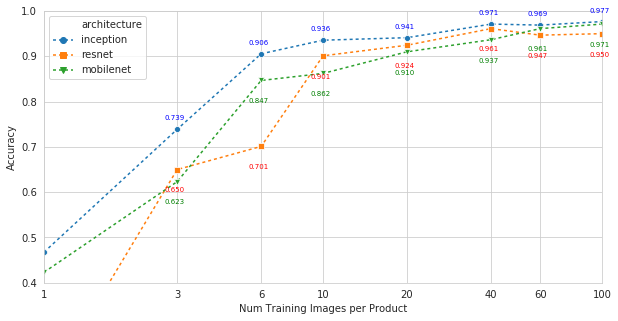

In [0]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

param_dict = {"architecture": ["inception", #_v2_075_128 - Test",
                               "resnet", #_v2_50 - Test",
                               "mobilenet"], #_resnet_v2 - Test"], 
              "k_fold":[1, 3, 6, 10, 20, 40, 60, 100],
              "kit": [0]}

param_grid = create_hyperparam_grid(param_dict)
index = ["architecture", "k_fold", "kit", "score"]

k = 1

df = pd.DataFrame(param_grid, columns=index)
print(df["architecture"].unique())
_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    filep = file.split(".csv")[0].split("_")
    score = pd.read_csv(os.path.join(_dir, file), sep=";")
    for kit in range(0,k):
      loc = ((df["architecture"] == filep[7]) &
             (df["k_fold"] == int(filep[-3])) & 
             (df["kit"] == kit))
      df.loc[loc, "score"] = score["('testing', {})".format(kit)].max(axis=0)
    
#_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
#for file in os.listdir(_dir):
#  if file.endswith(".csv"):
#    print("working on: ", file)
#    filep = file.split(".csv")[0].split("_")
#    score = pd.read_csv(os.path.join(_dir, file), sep=";")
#    for kit in range(0,k):
#      if "('validation', {})".format(kit) in score.keys():
#        loc = ((df["type"] == "_".join(filep[7:-3]) + " - Val") &
#               (df["k_fold"] == int(filep[-3])) &
#               (df["kit"] == kit))
#        df.loc[loc, "score"] = score["('validation', {})".format(kit)].max(axis=0)

#_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning", "hyperparam")
#for file in os.listdir(_dir):
#  if file.endswith(".csv"):
#    print("working on: ", file)
#    filep = file.split(".csv")[0].split("_")
#    score = pd.read_csv(os.path.join(_dir, file), sep=";")
#    for kit in range(0,5):
#      if "('validation', {})".format(kit) in score.keys():
#        loc = ((df["type"] == "FineTuning - Val") &
#               (df["tfhub_modules"] == "_".join(filep[7:-4])) &
#               (df["k_fold"] == int(filep[-3])) &
#               (df["regularization_rate"] == float(filep[-2].replace("-","."))) &
#               (df["learning_rate"] == float(filep[-1].replace("3e-05","0.00003").replace("-","."))) & 
#               (df["kit"] == kit))
#        df.loc[loc, "score"] = score["('validation', {})".format(kit)].max(axis=0)
      
#_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
#for file in os.listdir(_dir):
#  if file.endswith(".csv"):
#    print("working on: ", file)
#    filep = file.split(".csv")[0].split("_")
#    score = pd.read_csv(os.path.join(_dir, file), sep=";")
#    for kit in range(0,5):
#      loc = ((df["type"] == "FineTuning") &
#             (df["tfhub_modules"] == "_".join(filep[7:-4])) &
#             (df["k_fold"] == (int(filep[-4]),int(filep[-3]))) &
#             (df["regularization_rate"] == float(filep[-2].replace("-","."))) &
#             (df["learning_rate"] == float(filep[-1].replace("3e-05","0.00003").replace("-","."))) & 
#             (df["kit"] == kit))
      

# Plot the responses for different events and regions
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
g = sns.lineplot(x="k_fold", y="score",
                 hue= "architecture",
                 style = "architecture",
                 ax=ax,
                 data=df,
                 markers=['o','s','v'],
                 dashes=[(2,2),(2,2),(2,2)])
plt.legend(loc='upper left')
g.set(xlim = (1,100))
#xlabels = ['{}'.format(int(x)) for x in g.get_xticks()]
xlabels = [1, 3, 6, 10, 20, 40, 60, 100]
g.set_xticks(xlabels)
g.set_xticklabels(xlabels)
g.set(ylim = (0.4,1.0))
ax.set(xlabel='Num Training Images per Product', ylabel='Accuracy')
row = df[(df["architecture"]=="inception") & (df["k_fold"] == 100)].values[0]
for index, row in df.iterrows():
  r = row.values
  if r[1] < 2:
    continue
  if r[0] == "inception":
    c = "b"
    o = 0.02
  elif r[0] == "mobilenet":
    c = "g"
    o = -0.05
  elif r[0] == "resnet":
    c = "r"
    o = -0.05
  plt.text(0.9*r[1], r[3]+o,
           "{:.3f}".format(r[3]),
           fontsize=7,
           color=c) #TODO set color similar to text

df

# Evaluate Missclassifieds

In [0]:
import os
import pandas as pd

pairs = pd.DataFrame(columns = ["correct","false","cnt"])
missed_files = pd.DataFrame(columns=["cnt"])


_dir = "/content/gdrive/My Drive/Masterarbeit/ImageClassification/Missclassified/FineTuning"
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    missclassifieds = pd.read_csv(os.path.join(_dir, file), sep=";")
    #correct_label	false_label image_file
    for index, row in missclassifieds.iterrows():
      pos = (pairs["correct"] == row["correct_label"]) & (pairs["false"] == row["false_label"])
      if any(pos):
        pairs.loc[pos, "cnt"] += 1
      else:
        pairs = pairs.append(pd.Series({"correct": row["correct_label"],
                                "false": row["false_label"],
                                "cnt": 0}),
                     ignore_index=True)
      
      if not row["image_file"] in missed_files.index.values:
        missed_files.loc[row["image_file"], "cnt"] = 0
      missed_files.loc[row["image_file"], "cnt"] += 1
        

working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_100_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_60_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_40_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_20_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_10_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_6_0-01_0-003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_3_0-01_0-003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_1_0-01_0-003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_100_0-01_0-0003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_60_0-01_0-0003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_40_0-01_0-0003_0-1.csv
working on:  201

In [0]:
prods = {
  "7days_croissantschoko_packung_80_1_0000000000003":0,
  "airwaves_menthoneucalyptus_riegel_14_1_50173167":0,
  "balisto_muesli__37g__5000159418546":0,
  "berger_zitronetoertli__50__7610404511007":0,
  "berger_spitzbueb__74__7610404591009":0,
  "bifi_roll__50__4251097402635":0,
  "bueno___43__4008400320328":0,
  "c+swiss_dosenabisicetea__33__9120025930135":1,
  "caferoyal_classicmacchiato__33__7617014164487":0,
  "caprisun_multivitamin__20__4000177605004":1,
  "coke_zero_flasche_50__5449000131836":1,
  "coke__dose_33__54491472":1,
  "coke___50__54491472":1,
  "comella_schokodrink__33__7613100037253":0,
  "darwida_sandwich____7610032065170":0,  
  "evian___50__3068320353500":2,  
  "fanta___50__40822938":1,
  "fini_galaxymix_packung_100_1_8410525150364":0,
  "fini_jellykisses_packung_80_1_8410525116704":0,
  "fuse_peach__50__5449000236623":1,
  "fuse_lemon__50__5449000235947":1,
  "fuse_lemon_dose_33__5449000235947":1,
  "granini_orange__50__4002160092334":1, 
  "henniez_rot__33__7610235000442":2,
  "henniez_gruen__33__7610235000442":2,
  "henniez_blau__33__7610235000442":2,
  "jacklinks_beefjerkyorginal__25__4047751730219":0,
  "jlbrichard_gauffrechoko__90__5410495002079":0,
  "jlbrichard_gauffre__90__5410495002000":0,
  "kagi___50__7610046000259":0,
  "kind_darkchocnutsseasalt__40__0602652176517":0,
  "knoppers_riegel____4035800488808":0,
  "lorenz_nicnacs__40__4018077798818":0,
  "malburner_partysticks__40__7610200279682":0,
  "maltesers___100__5000159023061":0,
  "maltesers_teasers__35__5000159462129":0,
  "milka_tender____0000000000008":0,
  "mnms_gelb__45__40111445":0,
  "mezzomix___50__54490840":1,  
  "oreo___66__84100733":0,
  "pepsi_max__50__4060800105943":1,
  "powerbar_proteinplusschoko__55__4029679520028":0,
  "ragusa___50__76401121":0,
  "ramseier_jusdepomme__50__7610057001078":1,
  "redbull___33__90162909":1,
  "redbull_light__33__90162800":1,
  "rivella_rot__50__7610097111072":1,
  "schweppes_citrus__50__7610238230617":1,
  "stimorol_wildcherry_riegel_14_1_57060330":0,
  "skittles_sour_riegel_51_1_0000000000004":0,
  "snickers___50__5000159461122":0,
  "stimorol_spearmint_riegel_14_1_0000000000005":0,
  "tiki_himbeerbrause_dose_33_1_0000000000001":1,
  "toffifee___33__4014400924275":0,
  "torino___46__76415272":0,
  "twix___50__5000159459228":0,
  "valser_vivabirne__50__7610335001530":1,
  "valser_still__50__7610335002575":2,
  "valser_classic__50__76404160":2,
  "vitaminwell_reload__50__7350042716388":1,
  "volvic_teeminze__50__3057640335648":1,
  "volvic_pinapple__50__305764335648":1,
  "zweifel_graneochilli__100__7610095184009":0,
  "zweifel_paprika__90__7610095013002":0,
}

cnt= {"drink":0,
      "snack":0}

fuse_cases = ["fuse_peach__50__5449000236623",
              "fuse_peach__50__5449000236623"]
rb_cases = ["redbull___33__90162909",
              "redbull_light__33__90162800"]
coke_cases = ["coke___50__54491472",
              "coke_zero_flasche_50__5449000131836",
              "coke__dose_33__54491472"]
             
fuse_cnt = 0
rb_cnt = 0
coke_cnt = 0
for key, val in prods.items():
  keysums = pairs[["correct","cnt"]].groupby("correct").sum()
  if key in keysums.index.values:
    if val > 0:
      cnt["drink"] += keysums.loc[key,"cnt"]
    else:
      cnt["snack"] += keysums.loc[key,"cnt"]
    if key in fuse_cases:
      fuse_cnt += keysums.loc[key,"cnt"]
    elif key in rb_cases:
      rb_cnt += keysums.loc[key,"cnt"]
    elif key in coke_cases:
      coke_cnt += keysums.loc[key,"cnt"]
print(cnt["drink"]/ (cnt["drink"] + cnt["snack"]))
print((cnt["drink"] - fuse_cnt - rb_cnt - coke_cnt)/(cnt["drink"] + cnt["snack"]))
print((cnt["drink"] - fuse_cnt - rb_cnt - coke_cnt)/(cnt["drink"] + cnt["snack"] - fuse_cnt - rb_cnt - coke_cnt))
print(fuse_cnt/(cnt["drink"] + cnt["snack"]))
print(rb_cnt/(cnt["drink"] + cnt["snack"]))
print(coke_cnt/(cnt["drink"] + cnt["snack"]))

0.5932262569832403
0.2814245810055866
0.4089294774226281
0.09462290502793295
0.12081005586592179
0.09636871508379888


In [0]:
pairs[pairs["cnt"] > 0].sort_values("cnt", ascending=False)

,correct,false,cnt
6,fuse_peach__50__5449000236623,fuse_lemon__50__5449000235947,98
8,redbull___33__90162909,redbull_light__33__90162800,85
21,fuse_lemon__50__5449000235947,fuse_peach__50__5449000236623,79
12,mnms_gelb__45__40111445,bueno___43__4008400320328,23
0,coke_zero_flasche_50__5449000131836,coke__flasche_50__54491472,21
27,coke__flasche_50__54491472,coke__dose_33__54491472,19
14,redbull_light__33__90162800,redbull___33__90162909,19
52,coke__flasche_50__54491472,coke_zero_flasche_50__5449000131836,16
40,mnms_gelb__45__40111445,knoppers_riegel____4035800488808,8
15,oreo___66__84100733,valser_still__50__7610335002575,7


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

#print(missed_files.shape)
#print(missed_files["cnt"].value_counts().sort_index())
for index, row in missed_files[missed_files["cnt"] >= 3].sort_values("cnt", ascending=False).iterrows():
  print(row["cnt"],index)
  img = cv2.imread(index)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img/255)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_100_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_60_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_40_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_20_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_10_0-01_0-0003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_6_0-01_0-003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_3_0-01_0-003_0-1.csv
working on:  2019_6_15_16_33_25_missclassifieds_mobilenet_v2_075_128_1_0-01_0-003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_100_0-01_0-0003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_60_0-01_0-0003_0-1.csv
working on:  2019_6_15_17_55_41_missclassifieds_resnet_v2_50_40_0-01_0-0003_0-1.csv
working on:  201

,architecture,type,k,cnt,score
0,inception,normal,1,367,0.408065
1,resnet,normal,1,602,0.029032
2,mobilenet,normal,1,410,0.338710
3,inception,edge,1,67,0.162500
4,resnet,edge,1,90,-0.125000
5,mobilenet,edge,1,92,-0.150000
6,inception,normal,3,167,0.730645
7,resnet,normal,3,219,0.646774
8,mobilenet,normal,3,243,0.608065
9,inception,edge,3,49,0.387500


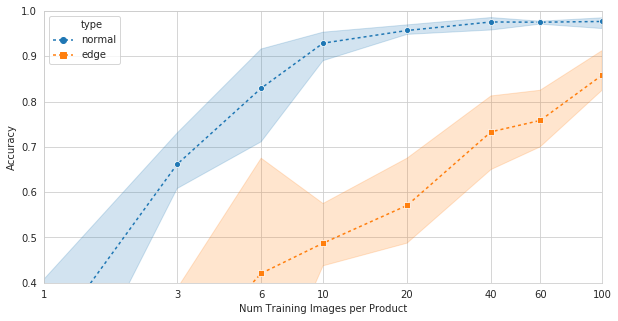

In [23]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pairs = pd.DataFrame(columns = ["correct","false","cnt"])

prods = {
  "7days_croissantschoko_packung_80_1_0000000000003":0,
  "airwaves_menthoneucalyptus_riegel_14_1_50173167":0,
  "balisto_muesli__37g__5000159418546":0,
  "berger_zitronetoertli__50__7610404511007":0,
  "berger_spitzbueb__74__7610404591009":0,
  "bifi_roll__50__4251097402635":0,
  "bueno___43__4008400320328":0,
  "c+swiss_dosenabisicetea__33__9120025930135":0,
  "caferoyal_classicmacchiato__33__7617014164487":0,
  "caprisun_multivitamin__20__4000177605004":0,
  "coke_zero_flasche_50__5449000131836":0,
  "coke__dose_33__54491472":0,
  "coke___50__54491472":0,
  "comella_schokodrink__33__7613100037253":0,
  "darwida_sandwich____7610032065170":0,  
  "evian___50__3068320353500":0,  
  "fanta___50__40822938":0,
  "fini_galaxymix_packung_100_1_8410525150364":0,
  "fini_jellykisses_packung_80_1_8410525116704":0,
  "fuse_peach__50__5449000236623":2,
  "fuse_lemon__50__5449000235947":2,
  "fuse_lemon_dose_33__5449000235947":0,
  "granini_orange__50__4002160092334":0, 
  "henniez_rot__33__7610235000442":0,
  "henniez_gruen__33__7610235000442":0,
  "henniez_blau__33__7610235000442":0,
  "jacklinks_beefjerkyorginal__25__4047751730219":0,
  "jlbrichard_gauffrechoko__90__5410495002079":0,
  "jlbrichard_gauffre__90__5410495002000":0,
  "kagi___50__7610046000259":0,
  "kind_darkchocnutsseasalt__40__0602652176517":0,
  "knoppers_riegel____4035800488808":0,
  "lorenz_nicnacs__40__4018077798818":0,
  "malburner_partysticks__40__7610200279682":0,
  "maltesers___100__5000159023061":0,
  "maltesers_teasers__35__5000159462129":0,
  "milka_tender____0000000000008":0,
  "mnms_gelb__45__40111445":0,
  "mezzomix___50__54490840":0,  
  "oreo___66__84100733":0,
  "pepsi_max__50__4060800105943":0,
  "powerbar_proteinplusschoko__55__4029679520028":0,
  "ragusa___50__76401121":0,
  "ramseier_jusdepomme__50__7610057001078":0,
  "redbull___33__90162909":2,
  "redbull_light__33__90162800":2,
  "rivella_rot__50__7610097111072":0,
  "schweppes_citrus__50__7610238230617":0,
  "stimorol_wildcherry_riegel_14_1_57060330":0,
  "skittles_sour_riegel_51_1_0000000000004":0,
  "snickers___50__5000159461122":0,
  "stimorol_spearmint_riegel_14_1_0000000000005":0,
  "tiki_himbeerbrause_dose_33_1_0000000000001":0,
  "toffifee___33__4014400924275":0,
  "torino___46__76415272":0,
  "twix___50__5000159459228":0,
  "valser_vivabirne__50__7610335001530":0,
  "valser_still__50__7610335002575":0,
  "valser_classic__50__76404160":0,
  "vitaminwell_reload__50__7350042716388":0,
  "volvic_teeminze__50__3057640335648":0,
  "volvic_pinapple__50__305764335648":0,
  "zweifel_graneochilli__100__7610095184009":0,
  "zweifel_paprika__90__7610095013002":0,
}

param_dict = {"architecture": ["inception", #_v2_075_128 - Test",
                               "resnet", #_v2_50 - Test",
                               "mobilenet"],
              "type": ["normal",
                       "edge"],
              "k":[1,3,6,10, 20, 40, 60, 100]}
param_grid = create_hyperparam_grid(param_dict)
index = ["architecture", "type", "k", "cnt", "score"]
df = pd.DataFrame(param_grid, columns=index)
df["score"]=0
df["cnt"]=0

cnts = {"normal": set(),
        "edge": set()}

_dir = "/content/gdrive/My Drive/Masterarbeit/ImageClassification/Missclassified/FineTuning"
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    arch = file.split("_")[7]
    k = int(file.split("_")[-4])
    missclassifieds = pd.read_csv(os.path.join(_dir, file), sep=";")
    #correct_label	false_label image_file
    keysums = missclassifieds["correct_label"].value_counts()
    for key, val in prods.items():
      if key in keysums.index.values:
        #if val == 1:
        #  if not key in cnts["drink"]:
        #    cnts["drink"].add(key)
        #  df.loc[(df["type"]=="drink") & (df["architecture"]==arch) & (df["k"]==k),"cnt"] += keysums.loc[key]
        if val == 2:
          if not key in cnts["edge"]:
            cnts["edge"].add(key)
          df.loc[(df["type"]=="edge") & (df["architecture"]==arch) & (df["k"]==k),"cnt"] += keysums.loc[key]
        else:
          if not key in cnts["normal"]:
            cnts["normal"].add(key)
          df.loc[(df["type"]=="normal") & (df["architecture"]==arch) & (df["k"]==k),"cnt"] += keysums.loc[key]
        
for _, row in df.iterrows():
  df.loc[(df["type"]==row["type"]) &
         (df["architecture"]==row["architecture"]) &
         (df["k"]==row["k"]), "score"] = 1- (row["cnt"] / (len(cnts[row["type"]]) * 20.0))
          
# Plot the responses for different events and regions
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
g = sns.lineplot(x="k", y="score",
                 hue= "type",
                 style = "type",
                 ax=ax,
                 data=df,
                 markers=['o','s','v'],
                 dashes=[(2,2),(2,2),(2,2)])
plt.legend(loc='upper left')
g.set(xlim = (1,100))
#xlabels = ['{}'.format(int(x)) for x in g.get_xticks()]
xticks = [1,3,6,10, 20, 40, 60, 100]
xlabels = [1,3,6,10, 20, 40, 60, 100]
g.set_xticks(xticks)
g.set_xticklabels(xlabels)
g.set_xticklabels(xlabels)
g.set(ylim = (0.4,1.0))
ax.set(xlabel='Num Training Images per Product', ylabel='Accuracy')
#row = df[(df["architecture"]=="inception") & (df["k_fold"] == 100)].values[0]
#for index, row in df.iterrows():
#  r = row.values
#  plt.text(0.9*r[1], r[3]+o,
#           "{:.3f}".format(r[3]),
#           fontsize=7,
#           color=c) #TODO set color similar to text

df

In [0]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns

pairs = pd.DataFrame(columns = ["correct","false","cnt"])

# 0 package
# 1 bar
# 2 can
# 3 bottle
# 4 tetra
# 5 edge
prods = {
  "7days_croissantschoko_packung_80_1_0000000000003":0,
  "airwaves_menthoneucalyptus_riegel_14_1_50173167":1,
  "balisto_muesli__37g__5000159418546":1,
  "berger_zitronetoertli__50__7610404511007":0,
  "berger_spitzbueb__74__7610404591009":0,
  "bifi_roll__50__4251097402635":0,
  "bueno___43__4008400320328":0,
  "c+swiss_dosenabisicetea__33__9120025930135":1,
  "caferoyal_classicmacchiato__33__7617014164487":0,
  "caprisun_multivitamin__20__4000177605004":1,
  "coke_zero_flasche_50__5449000131836":1,
  "coke__dose_33__54491472":1,
  "coke___50__54491472":1,
  "comella_schokodrink__33__7613100037253":0,
  "darwida_sandwich____7610032065170":0,  
  "evian___50__3068320353500":2,  
  "fanta___50__40822938":1,
  "fini_galaxymix_packung_100_1_8410525150364":0,
  "fini_jellykisses_packung_80_1_8410525116704":0,
  "fuse_peach__50__5449000236623":1,
  "fuse_lemon__50__5449000235947":1,
  "fuse_lemon_dose_33__5449000235947":1,
  "granini_orange__50__4002160092334":1, 
  "henniez_rot__33__7610235000442":2,
  "henniez_gruen__33__7610235000442":2,
  "henniez_blau__33__7610235000442":2,
  "jacklinks_beefjerkyorginal__25__4047751730219":0,
  "jlbrichard_gauffrechoko__90__5410495002079":0,
  "jlbrichard_gauffre__90__5410495002000":0,
  "kagi___50__7610046000259":0,
  "kind_darkchocnutsseasalt__40__0602652176517":0,
  "knoppers_riegel____4035800488808":0,
  "lorenz_nicnacs__40__4018077798818":0,
  "malburner_partysticks__40__7610200279682":0,
  "maltesers___100__5000159023061":0,
  "maltesers_teasers__35__5000159462129":0,
  "milka_tender____0000000000008":0,
  "mnms_gelb__45__40111445":0,
  "mezzomix___50__54490840":1,  
  "oreo___66__84100733":0,
  "pepsi_max__50__4060800105943":1,
  "powerbar_proteinplusschoko__55__4029679520028":0,
  "ragusa___50__76401121":0,
  "ramseier_jusdepomme__50__7610057001078":1,
  "redbull___33__90162909":1,
  "redbull_light__33__90162800":1,
  "rivella_rot__50__7610097111072":1,
  "schweppes_citrus__50__7610238230617":1,
  "stimorol_wildcherry_riegel_14_1_57060330":0,
  "skittles_sour_riegel_51_1_0000000000004":0,
  "snickers___50__5000159461122":0,
  "stimorol_spearmint_riegel_14_1_0000000000005":0,
  "tiki_himbeerbrause_dose_33_1_0000000000001":1,
  "toffifee___33__4014400924275":0,
  "torino___46__76415272":0,
  "twix___50__5000159459228":0,
  "valser_vivabirne__50__7610335001530":1,
  "valser_still__50__7610335002575":2,
  "valser_classic__50__76404160":2,
  "vitaminwell_reload__50__7350042716388":1,
  "volvic_teeminze__50__3057640335648":1,
  "volvic_pinapple__50__305764335648":1,
  "zweifel_graneochilli__100__7610095184009":0,
  "zweifel_paprika__90__7610095013002":0,
}

param_dict = {"architecture": ["inception", #_v2_075_128 - Test",
                               "resnet", #_v2_50 - Test",
                               "mobilenet"],
              "type": ["drink",
                       "snack"],
              "k":[1,3,6,10, 20, 40, 60, 100]}
param_grid = create_hyperparam_grid(param_dict)
index = ["architecture", "type", "k", "cnt", "score"]
df = pd.DataFrame(param_grid, columns=index)
df["score"]=0
df["cnt"]=0

cnts = {"drink": set(),
        "snack": set()}

_dir = "/content/gdrive/My Drive/Masterarbeit/ImageClassification/Missclassified/FineTuning"
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    arch = file.split("_")[7]
    k = int(file.split("_")[-4])
    missclassifieds = pd.read_csv(os.path.join(_dir, file), sep=";")
    #correct_label	false_label image_file
    keysums = missclassifieds["correct_label"].value_counts()
    for key, val in prods.items():
      if key in keysums.index.values:
        if val > 0:
          if not key in cnts["drink"]:
            cnts["drink"].add(key)
          df.loc[(df["type"]=="drink") & (df["architecture"]==arch) & (df["k"]==k),"cnt"] += keysums.loc[key]
        else:
          if not key in cnts["snack"]:
            cnts["snack"].add(key)
          df.loc[(df["type"]=="snack") & (df["architecture"]==arch) & (df["k"]==k),"cnt"] += keysums.loc[key]
        
for _, row in df.iterrows():
  df.loc[(df["type"]==row["type"]) &
         (df["architecture"]==row["architecture"]) &
         (df["k"]==row["k"]), "score"] = 1- (row["cnt"] / (len(cnts[row["type"]]) * 20.0))
          
# Plot the responses for different events and regions
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
g = sns.lineplot(x="k", y="score",
                 hue= "type",
                 style = "type",
                 ax=ax,
                 data=df,
                 markers=['o','s'],
                 dashes=[(2,2),(2,2)])
plt.legend(loc='upper left')
g.set(xlim = (1,100))
#xlabels = ['{}'.format(int(x)) for x in g.get_xticks()]
xticks = [1,3,6,10, 20, 40, 60, 100]
xlabels = [1,3,6,10, 20, 40, 60, 100]
g.set_xticks(xticks)
g.set_xticklabels(xlabels)
g.set_xticklabels(xlabels)
g.set(ylim = (0.4,1.0))
ax.set(xlabel='Num Training Images per Product', ylabel='Accuracy')
#row = df[(df["architecture"]=="inception") & (df["k_fold"] == 100)].values[0]
#for index, row in df.iterrows():
#  r = row.values
#  plt.text(0.9*r[1], r[3]+o,
#           "{:.3f}".format(r[3]),
#           fontsize=7,
#           color=c) #TODO set color similar to text

df